In [1]:
# To RUN the code, please change the PATH variable to the location of the folder in file database_main.py, line 14 and run this notebook. 
# Please keep all the contents of the folder uploaded in UB box to. run the code.
# This library contains the data loading part. While importing it, the data is fetched from CSV and load it into database. 
import mycredlib as m
import customer_segmentation
# Importing libraries required for our modelling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly
import chart_studio.plotly as py
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score,accuracy_score
from matplotlib.ticker import PercentFormatter
import plotly.express as px

1293
101113


In [2]:
# Initializing a variable with db name, we use this connection throughtout this notebook
db_file = 'normalized.db'  
conn_norm = m.create_connection(db_file, False)

In [3]:
# Displaying the row count of raw actual table, previous table and normalized actual_data table
with conn_norm:
    cursor = conn_norm.cursor()
    cursor.execute("select count(*) from actual_data_raw")
    actual_raw = cursor.fetchall()
    print('actual_data_raw',actual_raw)
    cursor.execute("select count(*) from previous_data")
    previous_raw = cursor.fetchall()
    print('previous_data',previous_raw)
    cursor.execute("select count(*) from actual_data_norm")
    actual_norm = cursor.fetchall()
    print('actual_data_norm',actual_norm)

actual_data_raw [(307511,)]
previous_data [(1310128,)]
actual_data_norm [(205105,)]


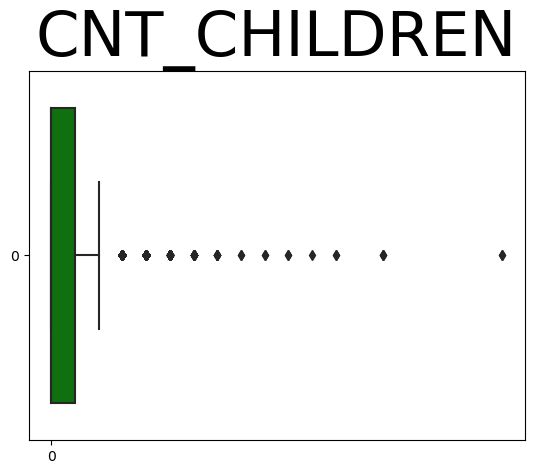

Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1289 ticks ([-5900000.0, ..., 122900000.0]), whic

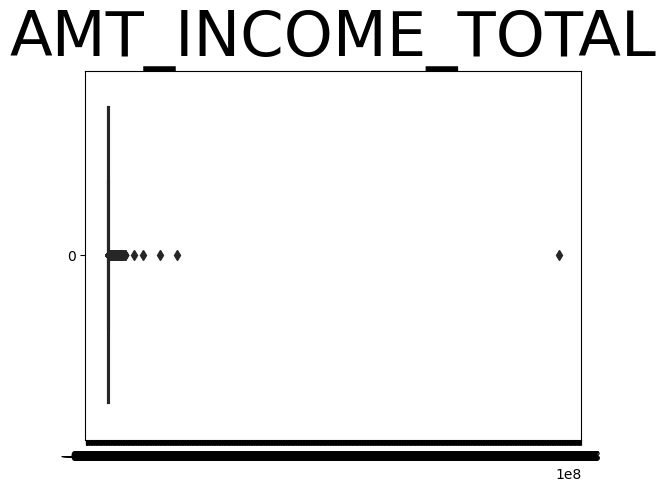

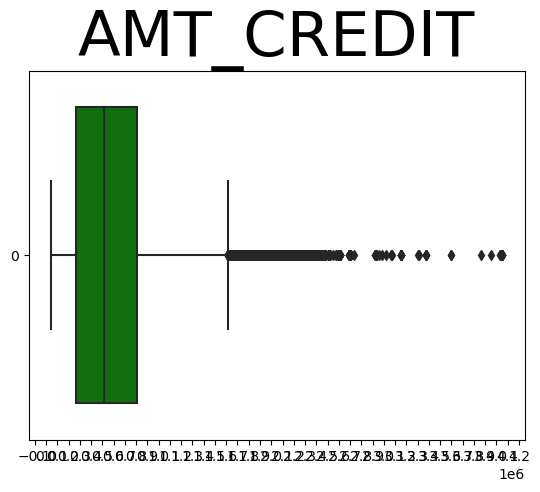

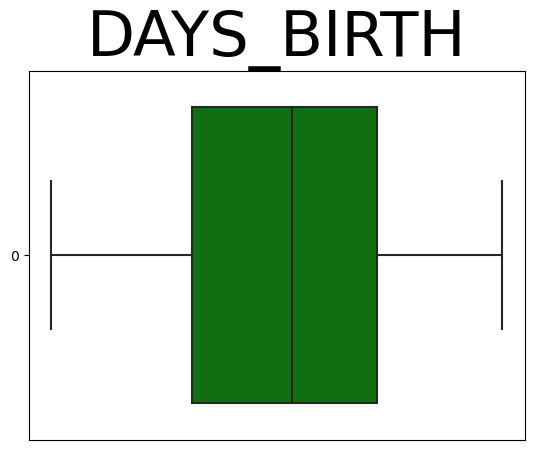

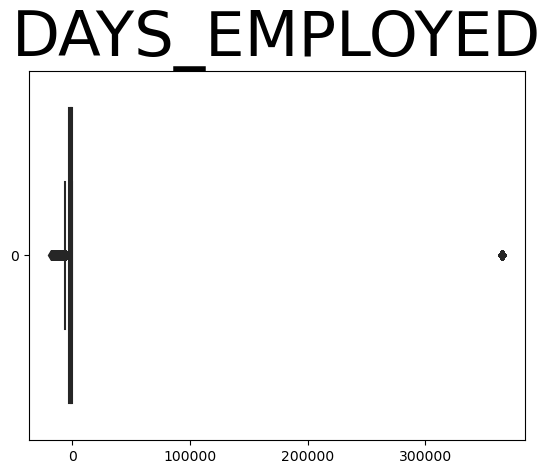

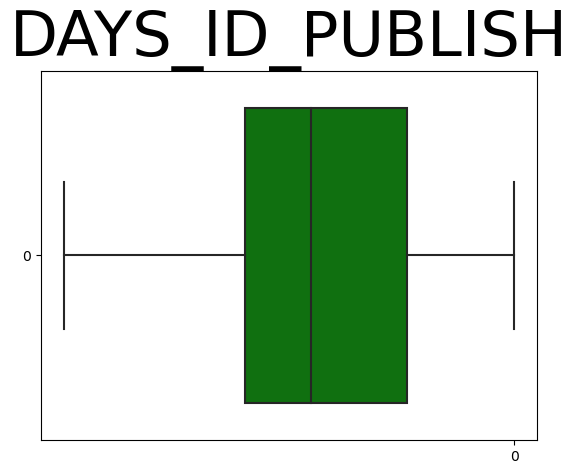

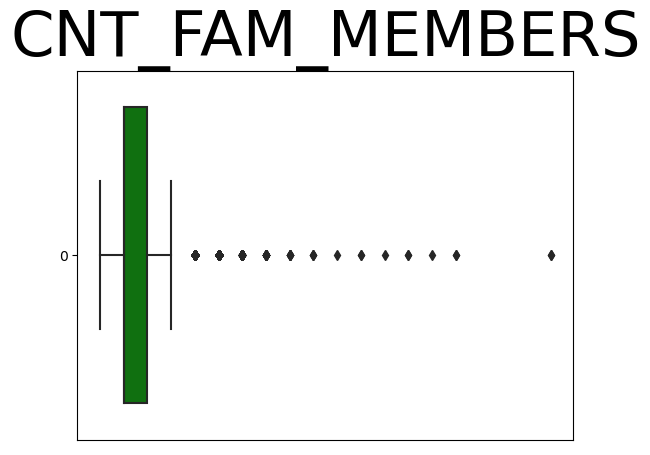

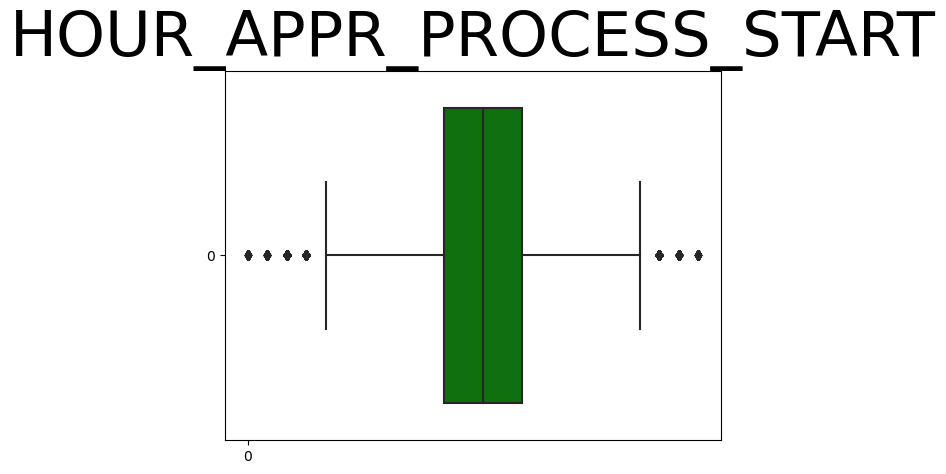

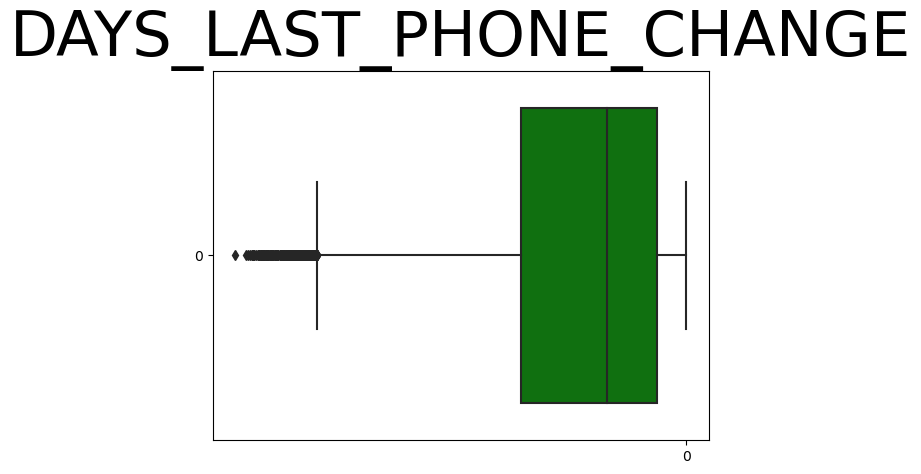

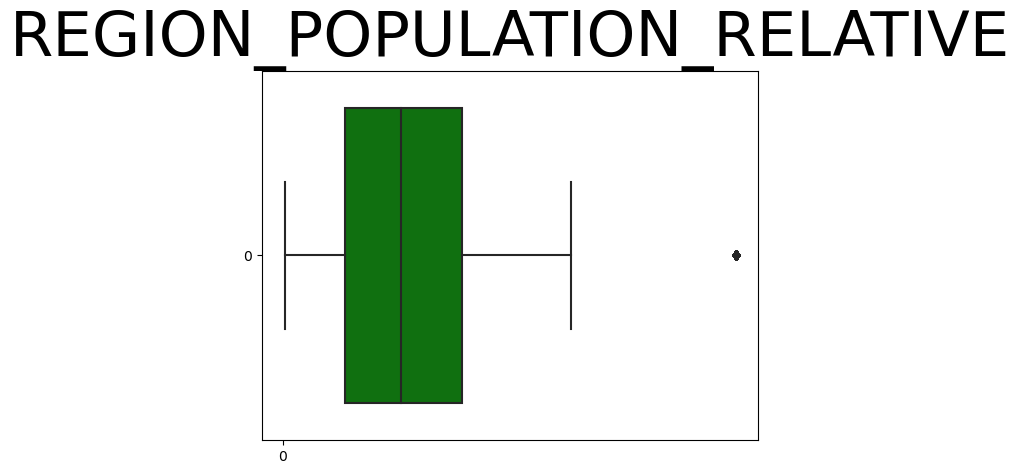

In [4]:
# Plotting the outliers in numerical columns
num_col_list = ['CNT_CHILDREN','AMT_INCOME_TOTAL',
       'AMT_CREDIT','DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH','CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
       'DAYS_LAST_PHONE_CHANGE',
       'REGION_POPULATION_RELATIVE']

def boxplots(df, i):
    #fig = plt.figure(figsize = (22,6))
    df = df[(df[i]!='')]
    ax = sns.boxplot(data = df[i], orient = 'h', color = 'green')
    ax.set_xscale('linear')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))
    ax.set_title(i, fontsize = 45)
    plt.show()
    
for i in num_col_list:
    sql = f'select {i} from actual_data_raw;'
    df = pd.read_sql_query(sql, conn_norm)
    boxplots(df, i)
    

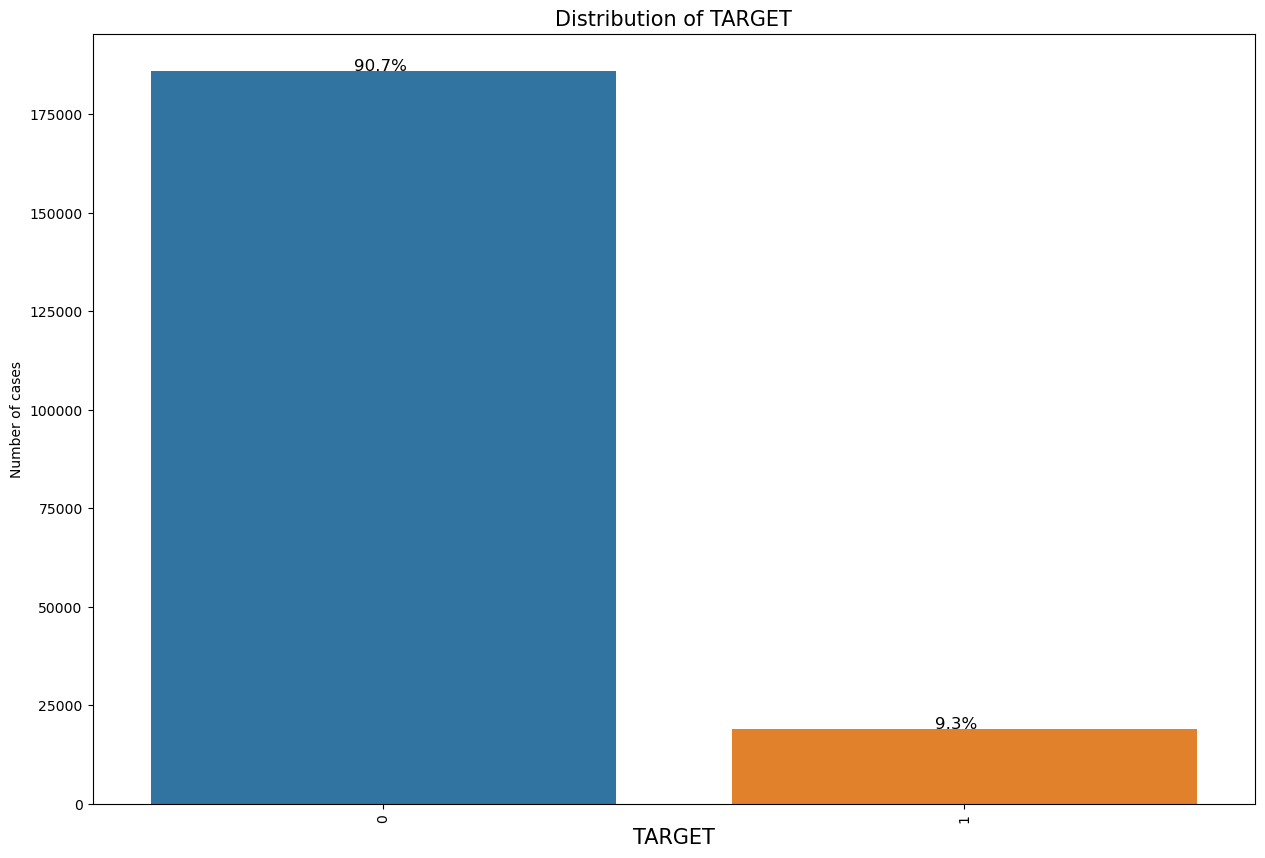

In [5]:
# Distribution of target
sql = 'select TARGET from actual_data_norm'
df = pd.read_sql_query(sql, conn_norm)

plt.figure(figsize = (15,10))
ax = sns.countplot('TARGET', data = df)
plt.title('Distribution of TARGET', fontsize=15)
plt.xlabel('TARGET', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Number of cases')

total = len(df.TARGET)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


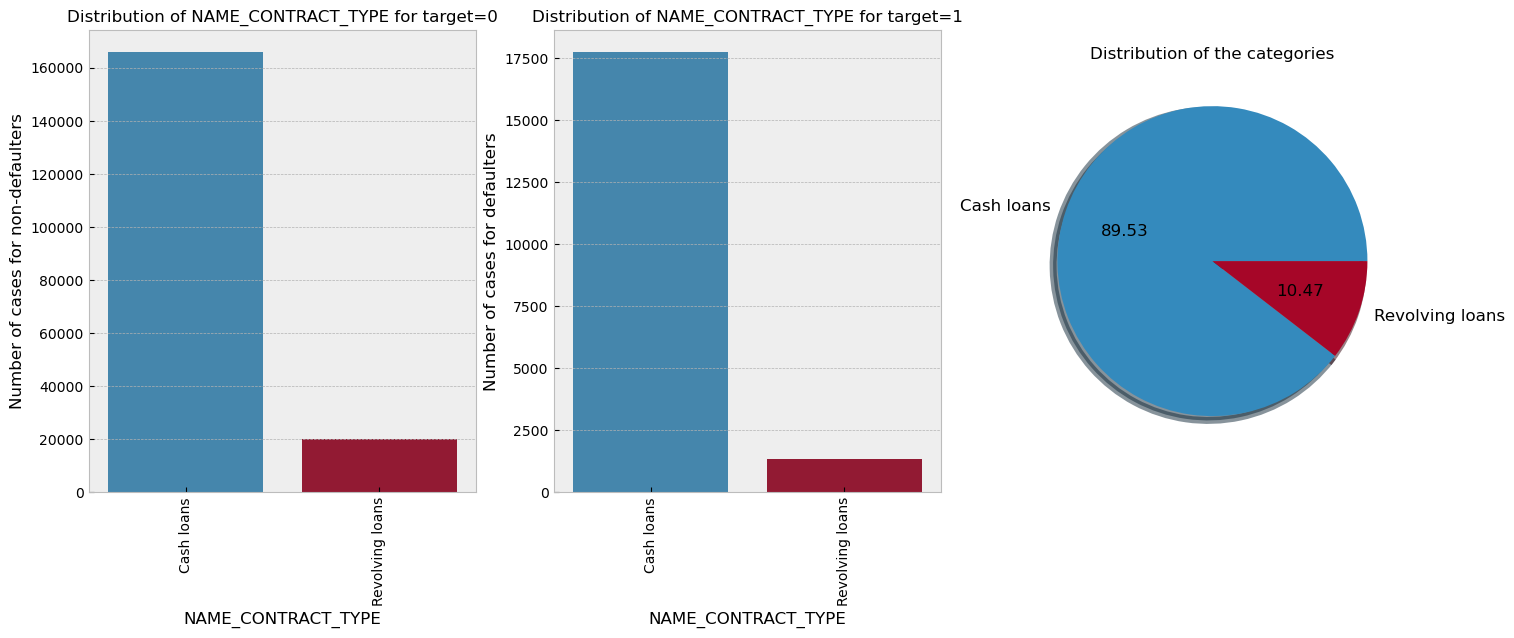

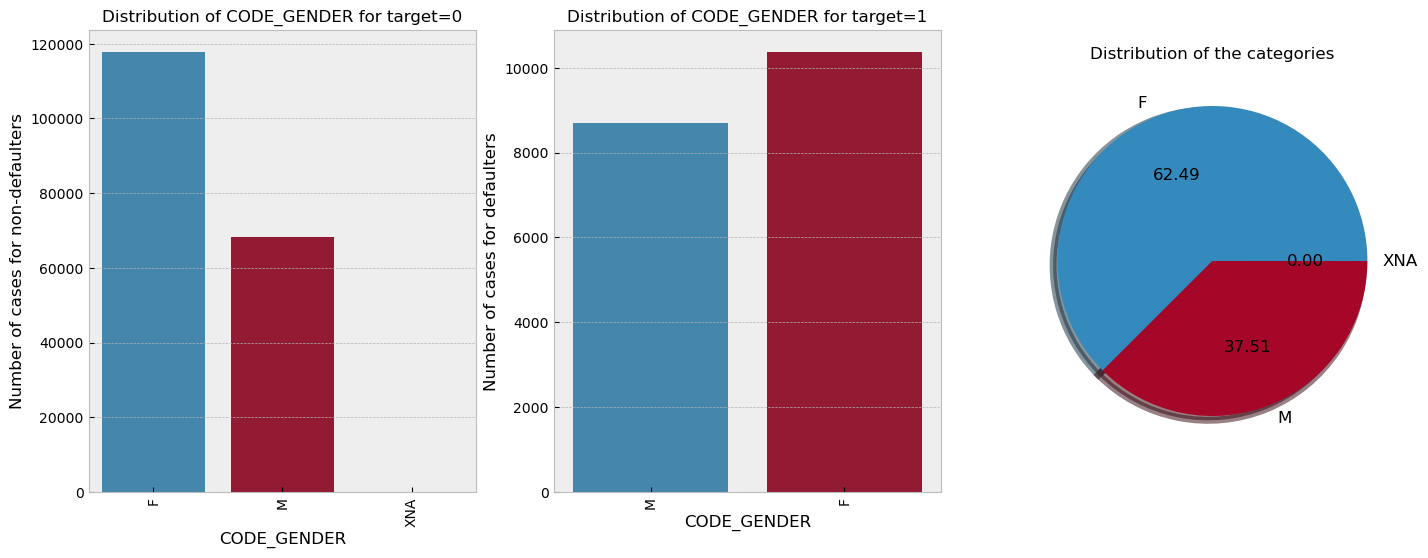

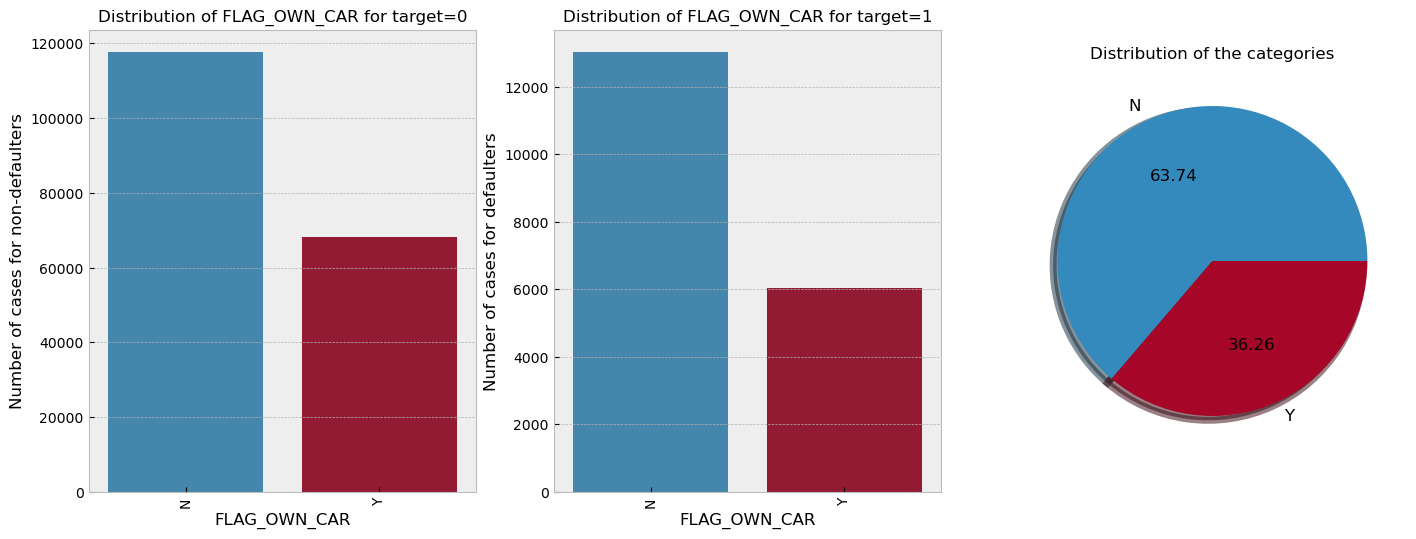

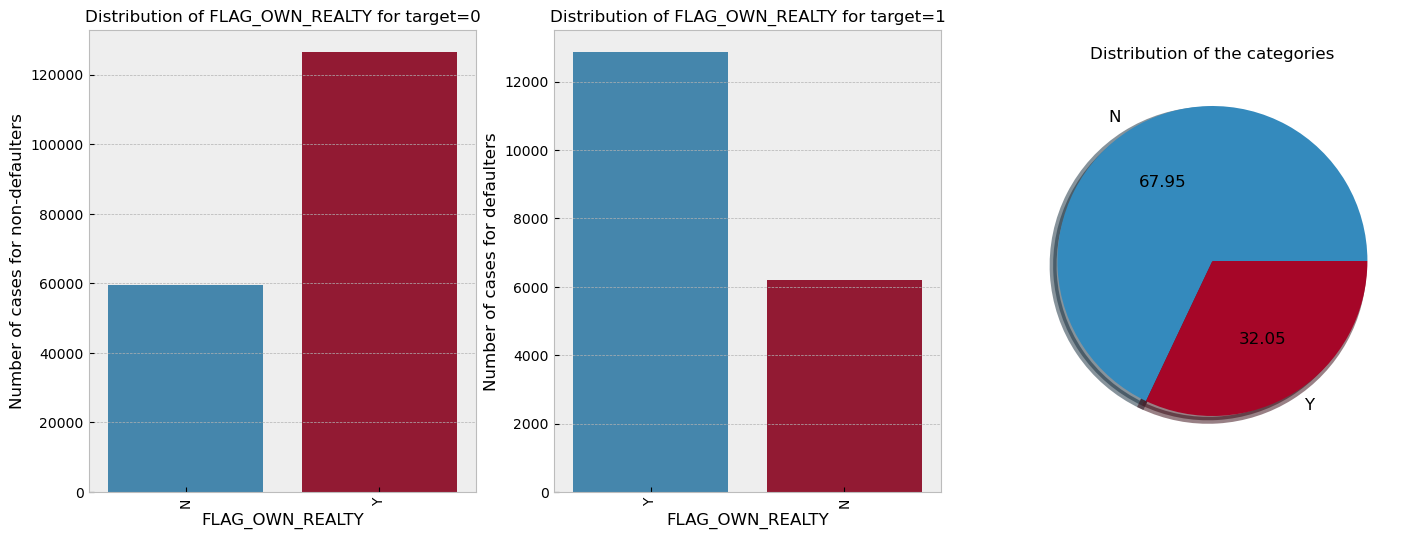

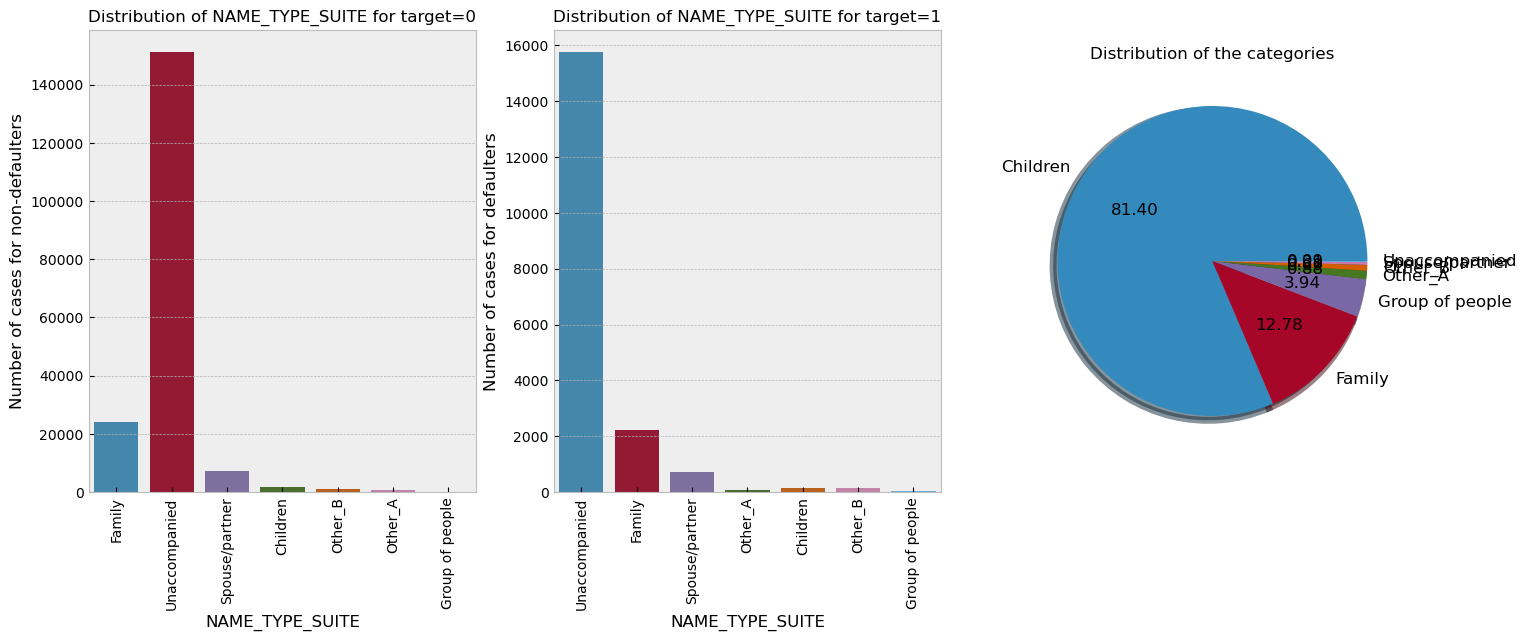

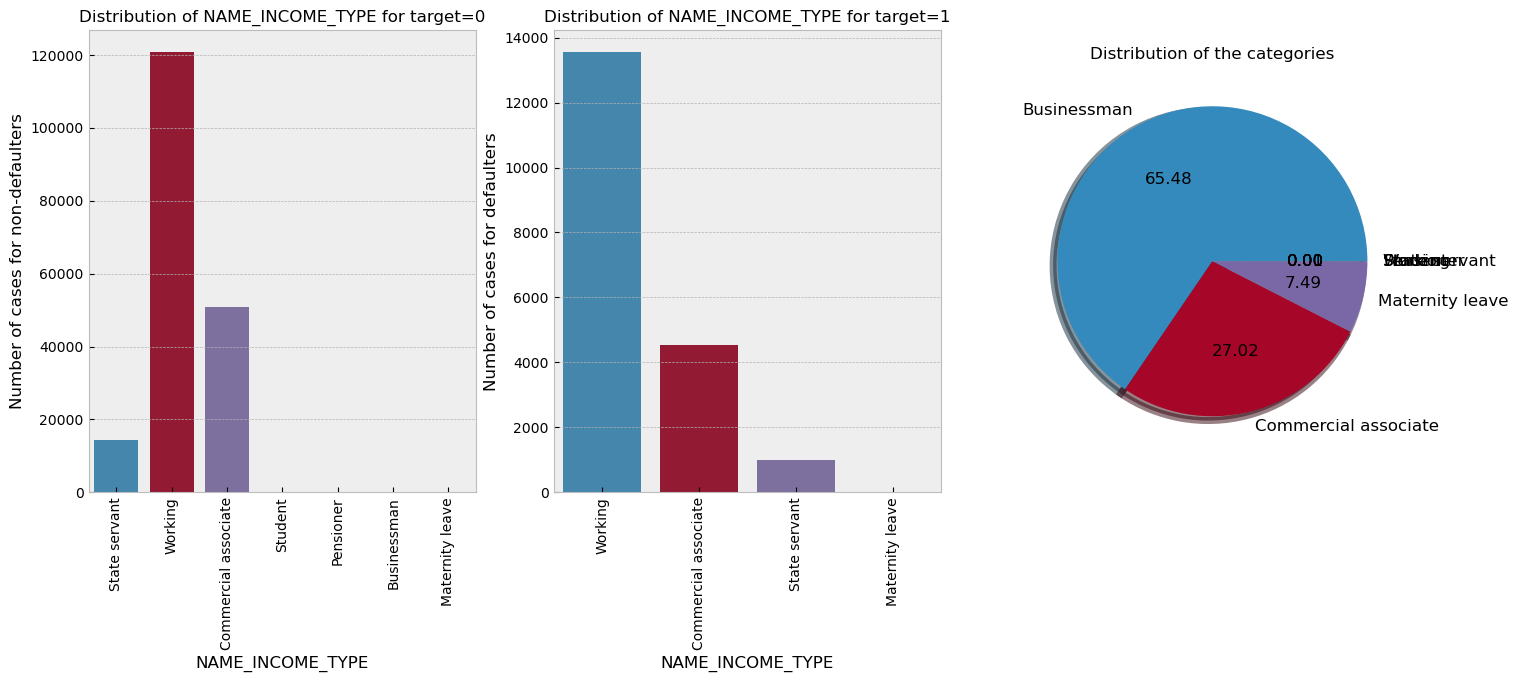

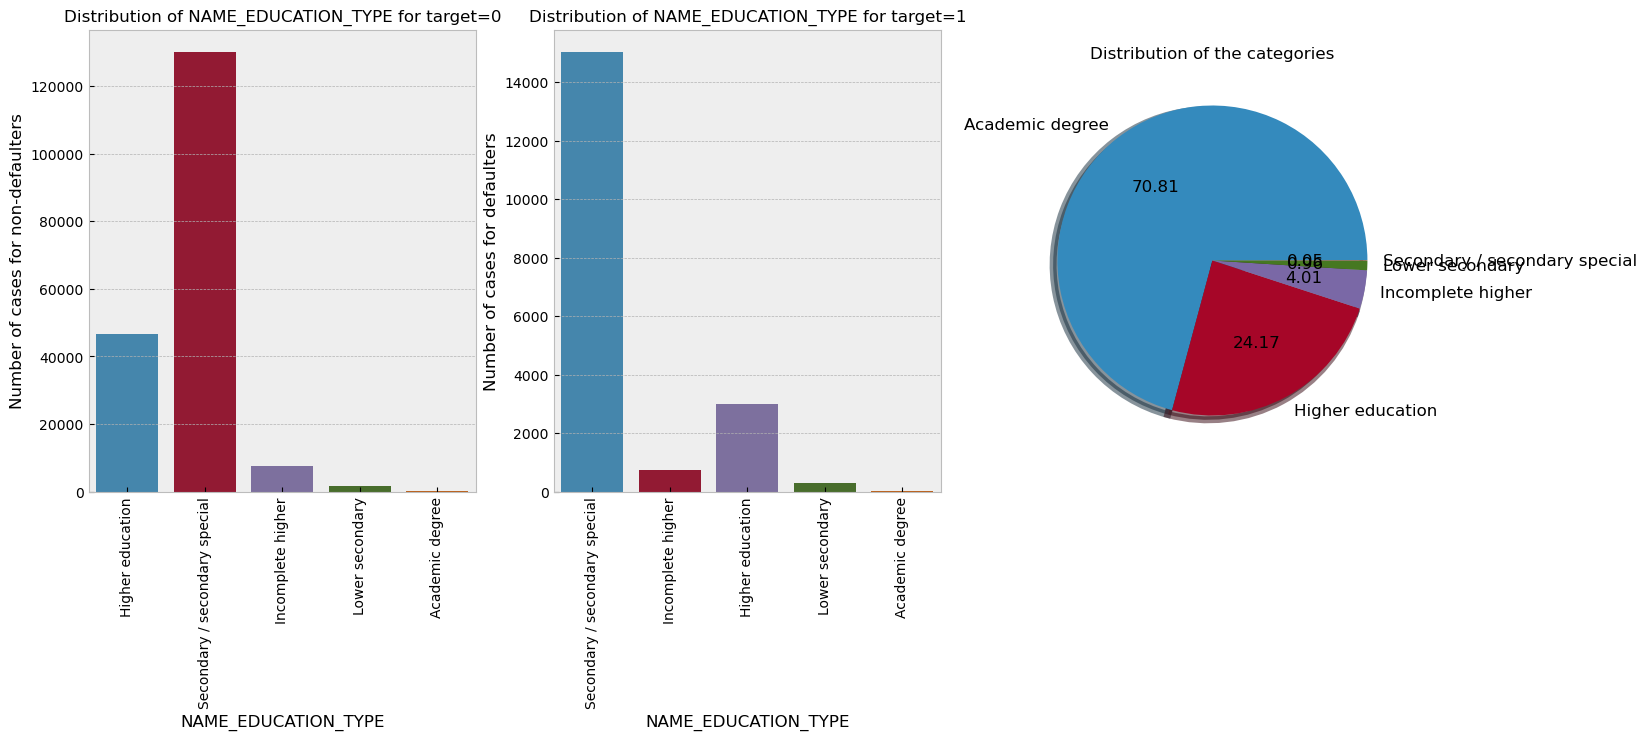

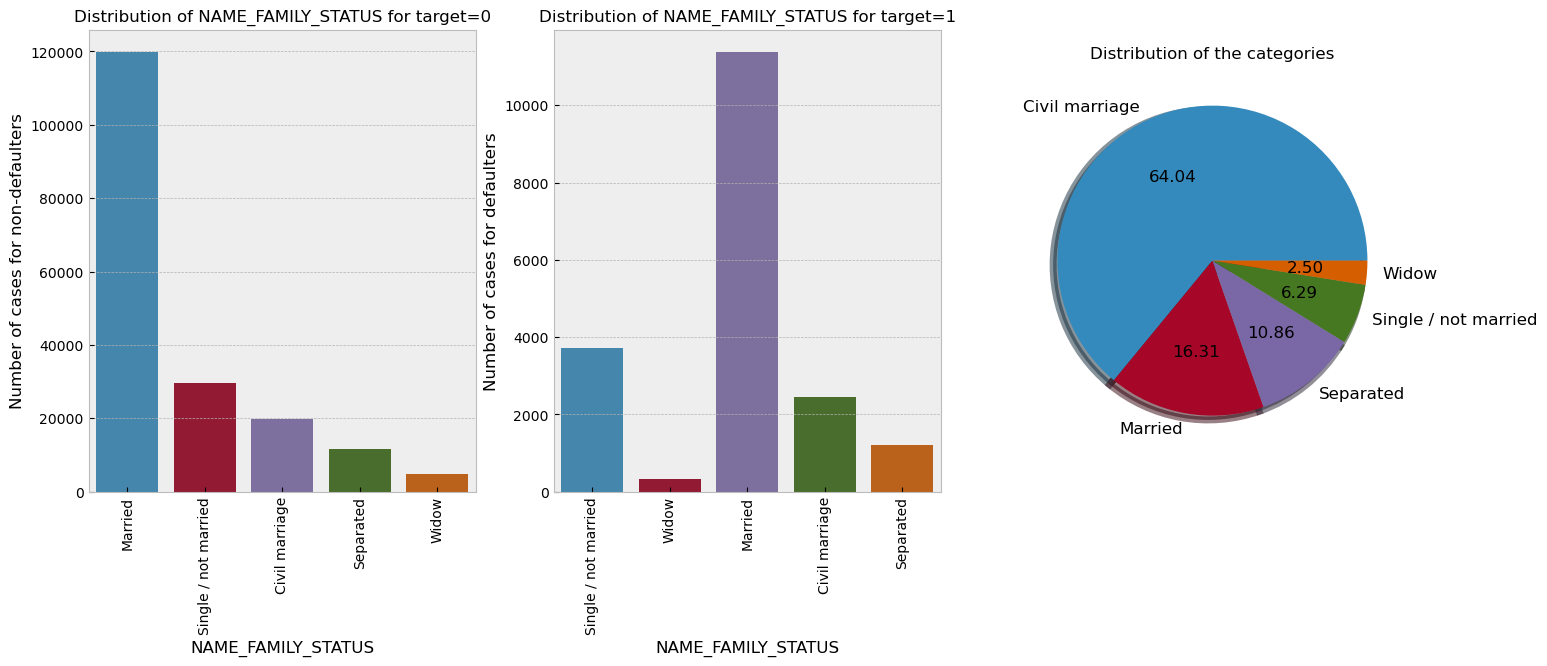

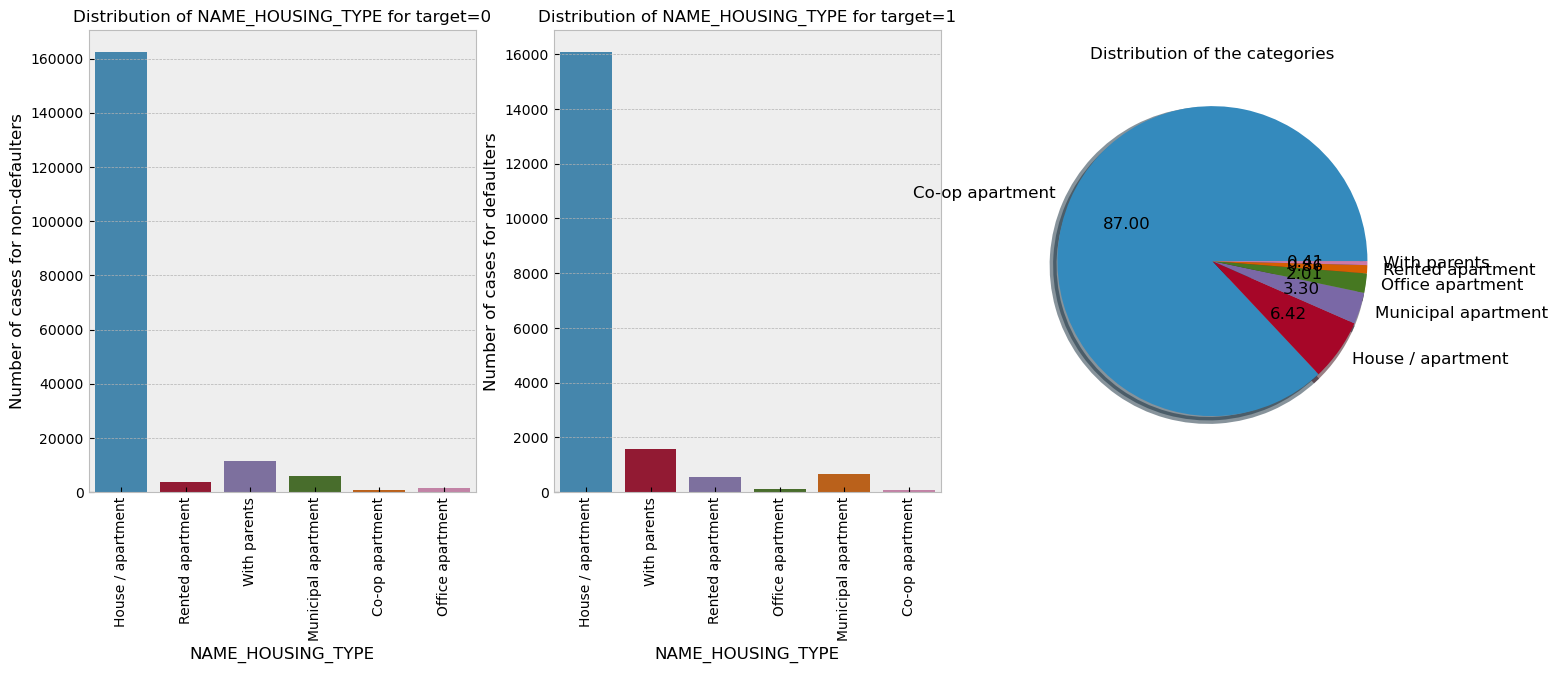

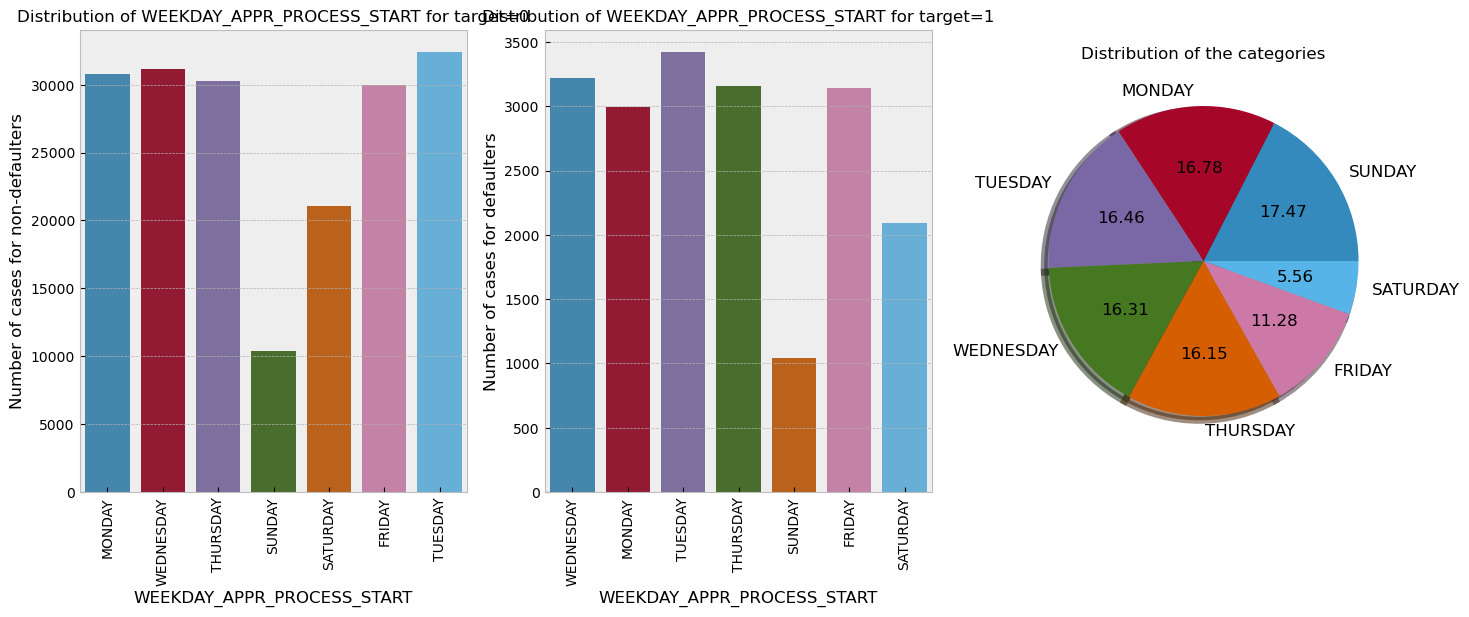

In [6]:
# Distribution analysis on categorical columns from actual_data_norm 
def graph_uni(i):
    
    sql = f'select tb.{i}, an.TARGET from actual_data_norm an, {i} tb where an.{i} = tb.ID'
    df = pd.read_sql_query(sql, conn_norm)
    plt.figure(figsize=(17,6))
    plt.style.use('bmh')
    plt.subplot(1, 3, 1)
    sns.countplot(i, data=df[df['TARGET'] == 0])
    plt.title('Distribution of '+ '%s' %i +' for target=0', fontsize=12)
    plt.xlabel(i , fontsize=12)
    plt.xticks(rotation=90)
    plt.ylabel('Number of cases for non-defaulters')
    
    plt.subplot(1, 3, 2)
    sns.countplot(i, data=df[df['TARGET'] == 1])
    plt.title('Distribution of '+ '%s' %i +' for target=1', fontsize=12)
    plt.xlabel(i , fontsize=12)
    plt.xticks(rotation=90)
    plt.ylabel('Number of cases for defaulters')
    
    sql2 = f'select distinct tb.{i} from {i} tb'
    with conn_norm:
        crsr = conn_norm.cursor()
        crsr.execute(sql2)
        result = crsr.fetchall()
        
    titles = [x[0] for x in result]
    
    plt.subplot(1, 3, 3)
    ax = plt.pie(x=df[i].value_counts(normalize=True),autopct='%.2f',textprops={'fontsize':12},shadow=True,labels=titles,wedgeprops = {'linewidth': 5}) 
    plt.title('Distribution of the categories',fontsize=12)
    plt.show();
    
cat_col_list = [ 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START']

for i in cat_col_list:
    graph_uni(i)

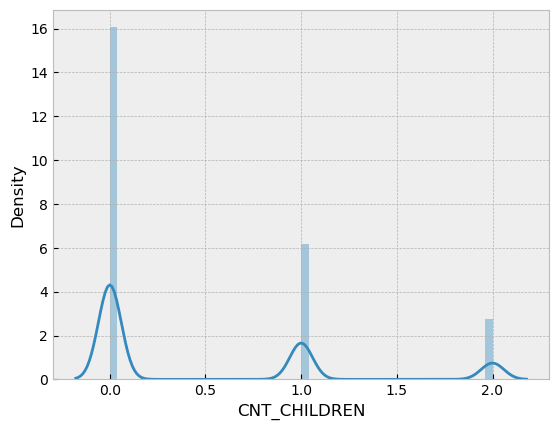

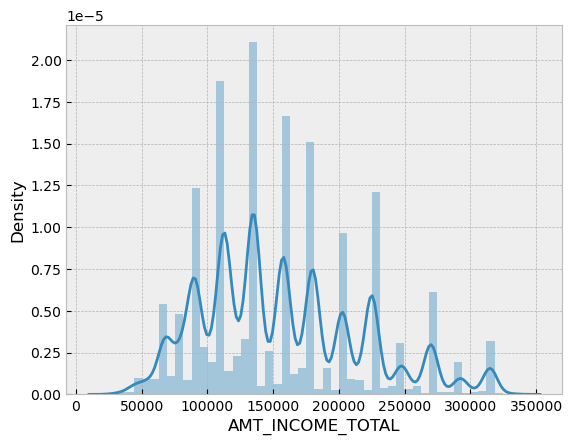

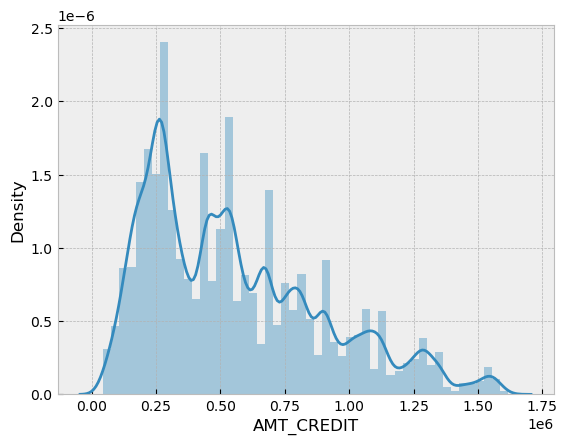

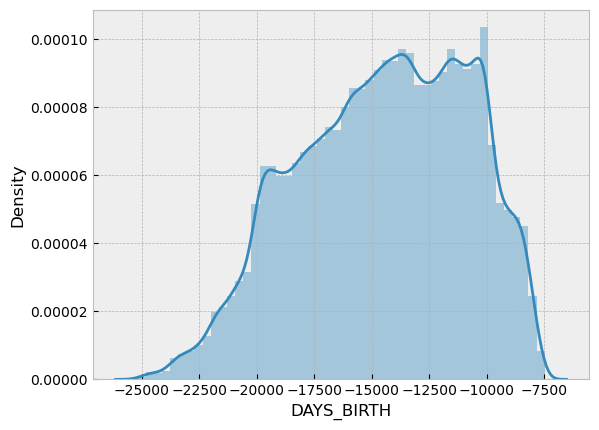

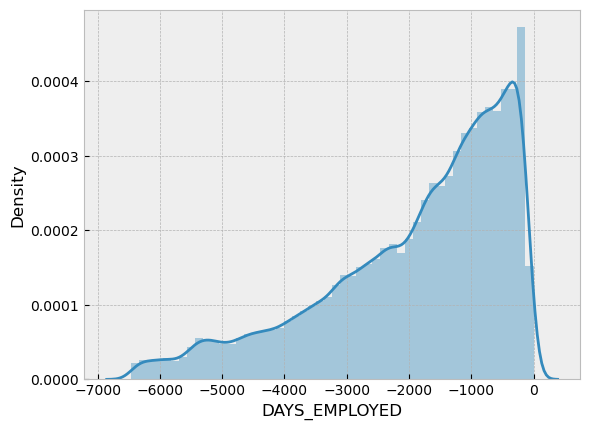

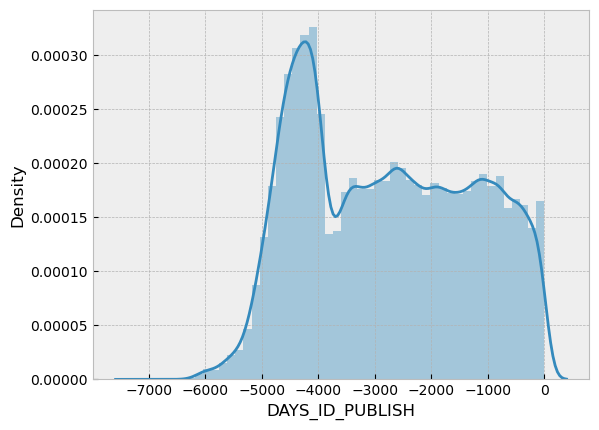

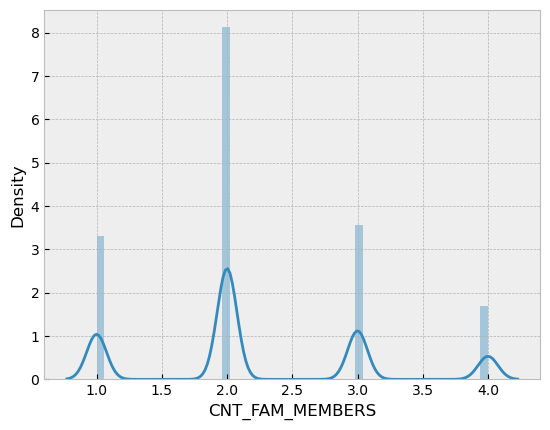

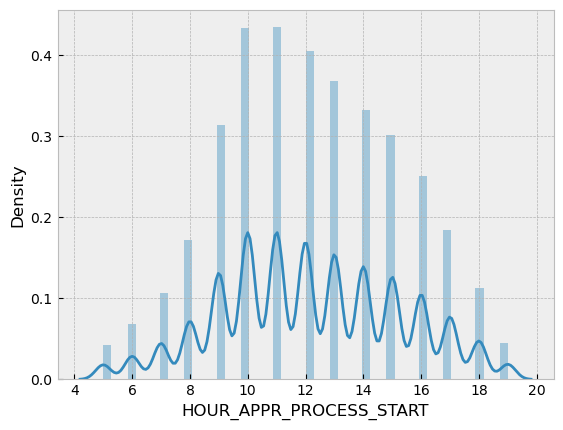

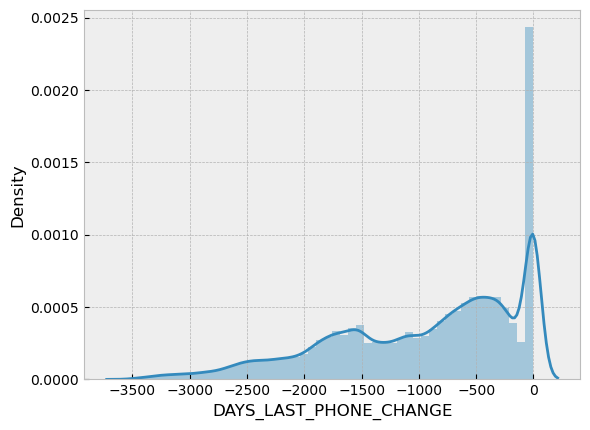

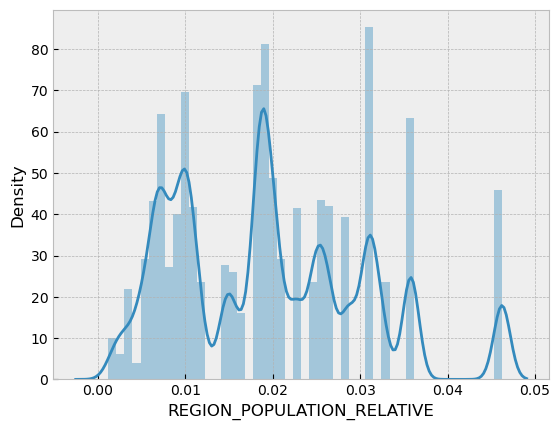

In [7]:
# Distribution analysis for numerical columns
num_col_list = ['CNT_CHILDREN','AMT_INCOME_TOTAL',
       'AMT_CREDIT','DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH','CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
       'DAYS_LAST_PHONE_CHANGE',
       'REGION_POPULATION_RELATIVE']


def distplots(df, i):
    sns.distplot(df[i])
    plt.show()
    
for i in num_col_list:
    sql = f'select {i} from actual_data_norm;'
    df = pd.read_sql_query(sql, conn_norm)
    distplots(df, i)

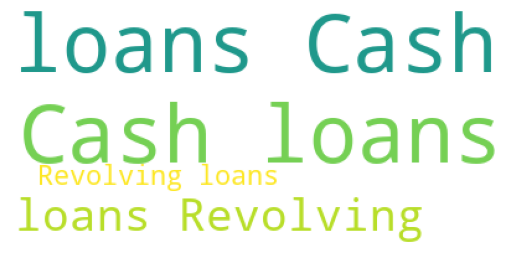

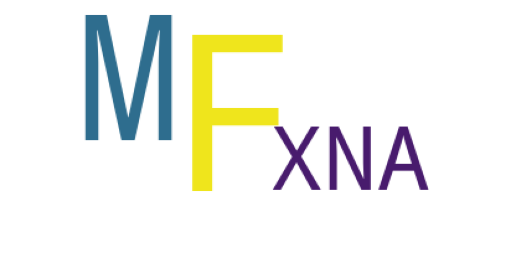

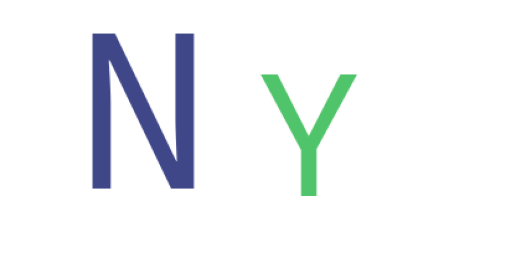

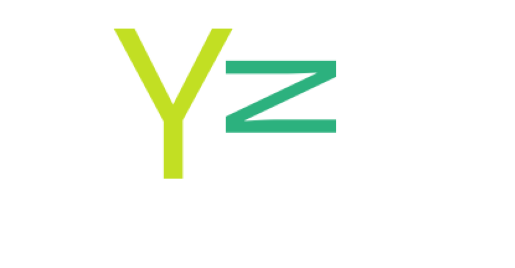

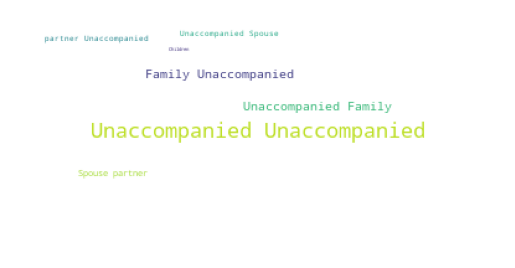

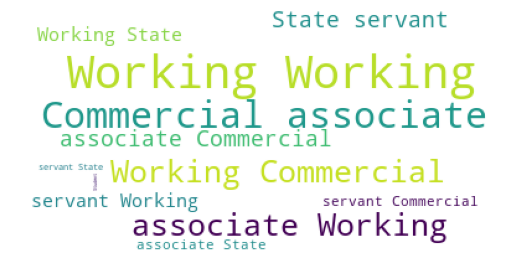

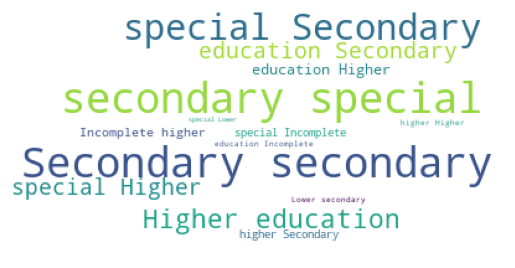

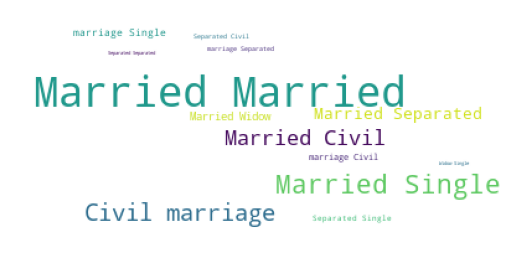

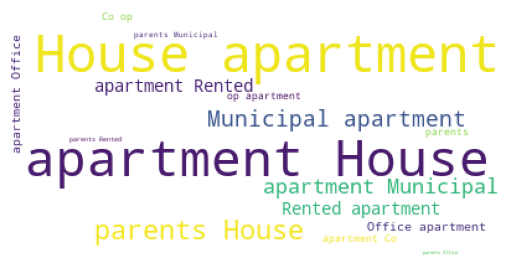

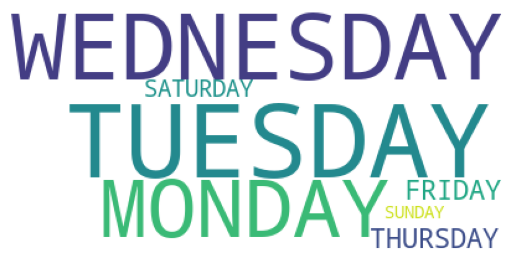

In [8]:
# Worlcloud to find out the prominent category in each categorical columns

cat_col_list = [ 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START']

def wordcloud(df, i):
    wordcloud2 = WordCloud(background_color = 'white').generate(' '.join(df[i]))
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.show()
    
for i in cat_col_list:
    sql = f'select tb.{i} from actual_data_norm an, {i} tb where an.{i} = tb.ID'
    df = pd.read_sql_query(sql, conn_norm)
    wordcloud(df, i)


In [9]:
# Creating list of categorical and numerical columns
cat_col_list = [ 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START']
num_col_list = ['SK_ID_CURR','TARGET','CNT_CHILDREN','AMT_INCOME_TOTAL',
       'AMT_CREDIT','DAYS_BIRTH_y', 'DAYS_EMPLOYED_y',
       'DAYS_ID_PUBLISH_y','CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
       'DAYS_LAST_PHONE_CHANGE_y',
       'REGION_POPULATION_RELATIVE',  'FLAG_MOBIL', 'FLAG_EMAIL','REGION_RATING_CLIENT_W_CITY']

In [10]:
# Function to fetch data from database
def fetch_col_data_from_db(conn_norm,table_name,col_list):
    sql_start = "select "
    sql_mid = ""
    sql_end = " from "+table_name
    for i in col_list:
        if not sql_mid:
            sql_mid += i
        else:
            sql_mid += ","+i
    sql = sql_start+sql_mid+sql_end
    df = pd.read_sql_query(sql, conn_norm)
    return df
df_categorical = fetch_col_data_from_db(conn_norm,'actual_data_norm', cat_col_list)
df_numerical = fetch_col_data_from_db(conn_norm,'actual_data_norm', num_col_list)


In [11]:
# Defining function for Sankey chart
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [12]:
# To display Sankey graph



sql = '''select (case when DAYS_EMPLOYED_y between 0 and 2 then 'Years Employed 0-2' \
when DAYS_EMPLOYED_y between 3 and 5 then 'Years Employed 3-5' when DAYS_EMPLOYED_y between 6 and 8 then 'Years Employed 6-8' \
when DAYS_EMPLOYED_y between 9 and 11 then 'Years Employed 9-11' when DAYS_EMPLOYED_y between 12 and 14 then 'Years Employed 12-14' \
when DAYS_EMPLOYED_y between 15 and 17 then 'Years Employed 15-17' end) as DAYS_EMPLOYED_y, (case when days_birth_y between 20 and 29 then 'Age 20-29' \
when days_birth_y between 30 and 39 then 'Age 30-39' when days_birth_y between 40 and 49 then 'Age 40-49' \
when days_birth_y between 50 and 59 then 'Age 50-59' when days_birth_y between 60 and 69 then 'Age 60-69' end) as DAYS_BIRTH_y, FS.NAME_FAMILY_STATUS, et.NAME_EDUCATION_TYPE, I.NAME_INCOME_TYPE, c.NAME_CONTRACT_TYPE from actual_data_norm an, \
NAME_INCOME_TYPE I, NAME_FAMILY_STATUS FS, NAME_EDUCATION_TYPE et, NAME_CONTRACT_TYPE c \
where an.NAME_INCOME_TYPE = I.ID and \
an.NAME_FAMILY_STATUS = FS.ID and an.NAME_EDUCATION_TYPE = et.ID and an.NAME_CONTRACT_TYPE = C.ID AND TARGET = 1;'''


df = pd.read_sql_query(sql, conn_norm)

df_agg = df.groupby(['DAYS_EMPLOYED_y','DAYS_BIRTH_y','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'])['NAME_CONTRACT_TYPE'].agg('count')

df_agg = pd.DataFrame(df_agg)
df_renamed = df_agg.rename(columns={'NAME_CONTRACT_TYPE':'value_cols'})
df_renamed.reset_index(inplace=True)
fig = genSankey(df_renamed,cat_cols=['DAYS_EMPLOYED_y','DAYS_BIRTH_y','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE','value_cols'],
                value_cols='value_cols',title='Sankey Diagram')
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

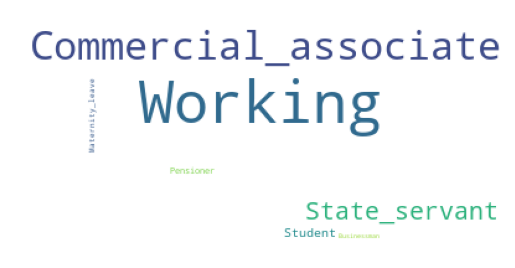

In [13]:
# Plotting charts that produce insights
# Working category are the maximum number of applicants
sql = '''with cte as (select ID, name_income_type, case when name_income_type = 'Businessman' then 'Businessman' 
when name_income_type = 'Commercial associate' then 'Commercial_associate' 
when name_income_type = 'Maternity leave' then 'Maternity_leave'
when name_income_type = 'Pensioner' then 'Pensioner' 
when name_income_type = 'State servant' then 'State_servant' 
when name_income_type = 'Student' then 'Student' 
when name_income_type = 'Working' then 'Working' end name_income_type_changed 
from name_income_type) 
select cte.name_income_type_changed from actual_data_norm ad, cte where 
ad.name_income_type = cte.ID; '''
df = pd.read_sql_query(sql, conn_norm)
wordcloud(df, 'name_income_type_changed')

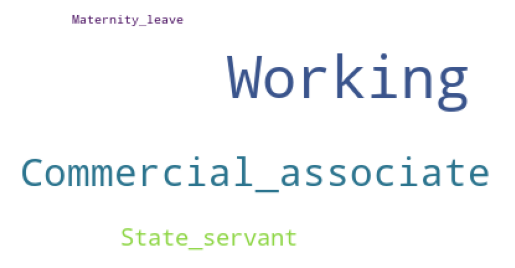

In [14]:
# Among the defaulters working category and commercial associates turn out to be high in number
sql = '''with cte as (select ID, name_income_type, case when name_income_type = 'Businessman' then 'Businessman' 
when name_income_type = 'Commercial associate' then 'Commercial_associate' 
when name_income_type = 'Maternity leave' then 'Maternity_leave'
when name_income_type = 'Pensioner' then 'Pensioner' 
when name_income_type = 'State servant' then 'State_servant' 
when name_income_type = 'Student' then 'Student' 
when name_income_type = 'Working' then 'Working' end name_income_type_changed 
from name_income_type) 
select cte.name_income_type_changed from actual_data_norm ad, cte where 
ad.name_income_type = cte.ID and ad.target = 1; '''
df = pd.read_sql_query(sql, conn_norm)
# display(df)
wordcloud(df, 'name_income_type_changed')

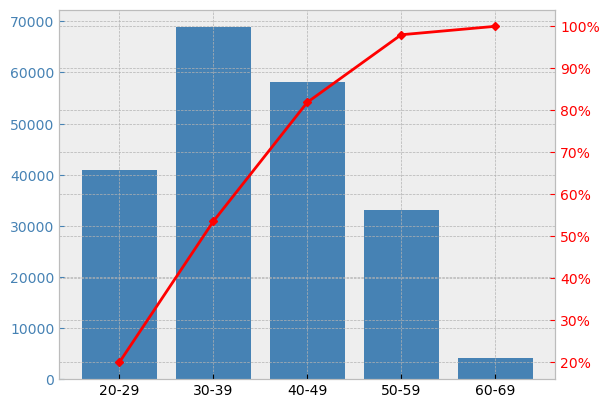

In [15]:
# Pareto chart showing applicants less than 50 years old are high in number
sql = ''' with cte as (select days_birth_y, case when days_birth_y between 20 and 29 then '20-29' 
when days_birth_y between 30 and 39 then '30-39' when days_birth_y between 40 and 49 then '40-49' 
when days_birth_y between 50 and 59 then '50-59' when days_birth_y between 60 and 69 then '60-69' end age_cat,
days_birth_y from actual_data_norm) 
select age_cat, count(age_cat) as total from cte 
group by age_cat;'''

df = pd.read_sql_query(sql, conn_norm)
df['percentage'] = (df['total'] / sum(df['total'])) * 100
df['cum_percent'] = 100 * (df['total'].cumsum()/df['total'].sum())

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(df.age_cat, df['total'], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df.index, df['cum_percent'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

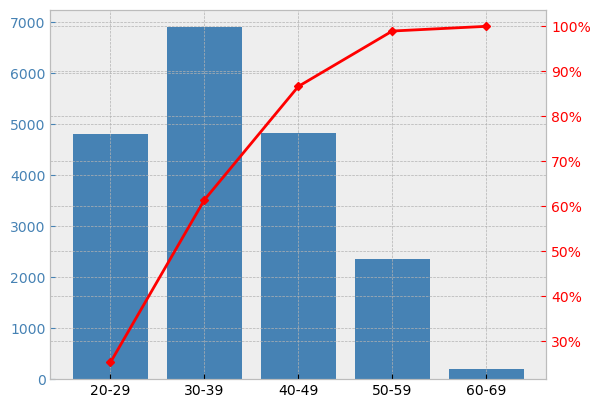

In [16]:
# Pareto chart showing applicants between 30 and 39 years old are high in defaulters
sql = ''' with cte as (select days_birth_y, case when days_birth_y between 20 and 29 then '20-29' 
when days_birth_y between 30 and 39 then '30-39' when days_birth_y between 40 and 49 then '40-49' 
when days_birth_y between 50 and 59 then '50-59' when days_birth_y between 60 and 69 then '60-69' end age_cat,
days_birth_y from actual_data_norm where target = 1) 
select age_cat, count(age_cat) as total from cte 
group by age_cat;'''
# (select count(*) from actual_data_norm))*100 as cumsum 
df = pd.read_sql_query(sql, conn_norm)
df['percentage'] = (df['total'] / sum(df['total'])) * 100
df['cum_percent'] = 100 * (df['total'].cumsum()/df['total'].sum())



#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(df.age_cat, df['total'], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df.index, df['cum_percent'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

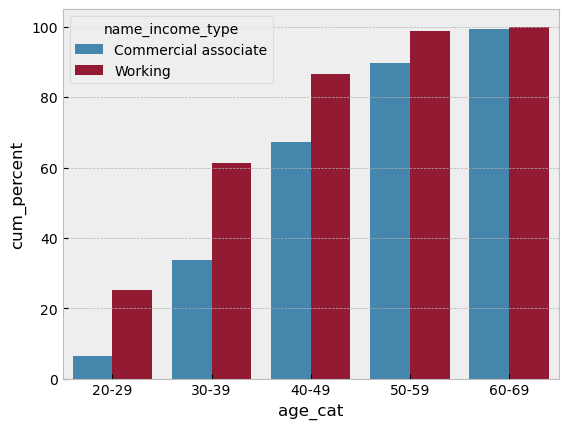

In [17]:
# Chart showing commerical associates and working category applicants are equally distributed across ages among defaulters
sql = ''' with cte as (select days_birth_y, case when days_birth_y between 20 and 29 then '20-29' 
when days_birth_y between 30 and 39 then '30-39' when days_birth_y between 40 and 49 then '40-49' 
when days_birth_y between 50 and 59 then '50-59' when days_birth_y between 60 and 69 then '60-69' end age_cat,
ic.name_income_type from actual_data_norm ad, name_income_type ic 
where ic.name_income_type in ('Working', 'Commercial associate') and 
ad.name_income_type = ic.ID and target = 1) 
select age_cat, name_income_type, count(age_cat) as total from cte 
group by age_cat, name_income_type;'''
# (select count(*) from actual_data_norm))*100 as cumsum 
df = pd.read_sql_query(sql, conn_norm)
df['percentage'] = (df['total'] / sum(df['total'])) * 100
df['cum_percent'] = 100 * (df['total'].cumsum()/df['total'].sum())

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

plt.figure()
sns.barplot(data = df, x = 'age_cat', y = 'cum_percent', hue = 'name_income_type')
plt.show()

<AxesSubplot:xlabel='WEEKDAY_APPR_PROCESS_START', ylabel='HOUR_APPR_PROCESS_START'>

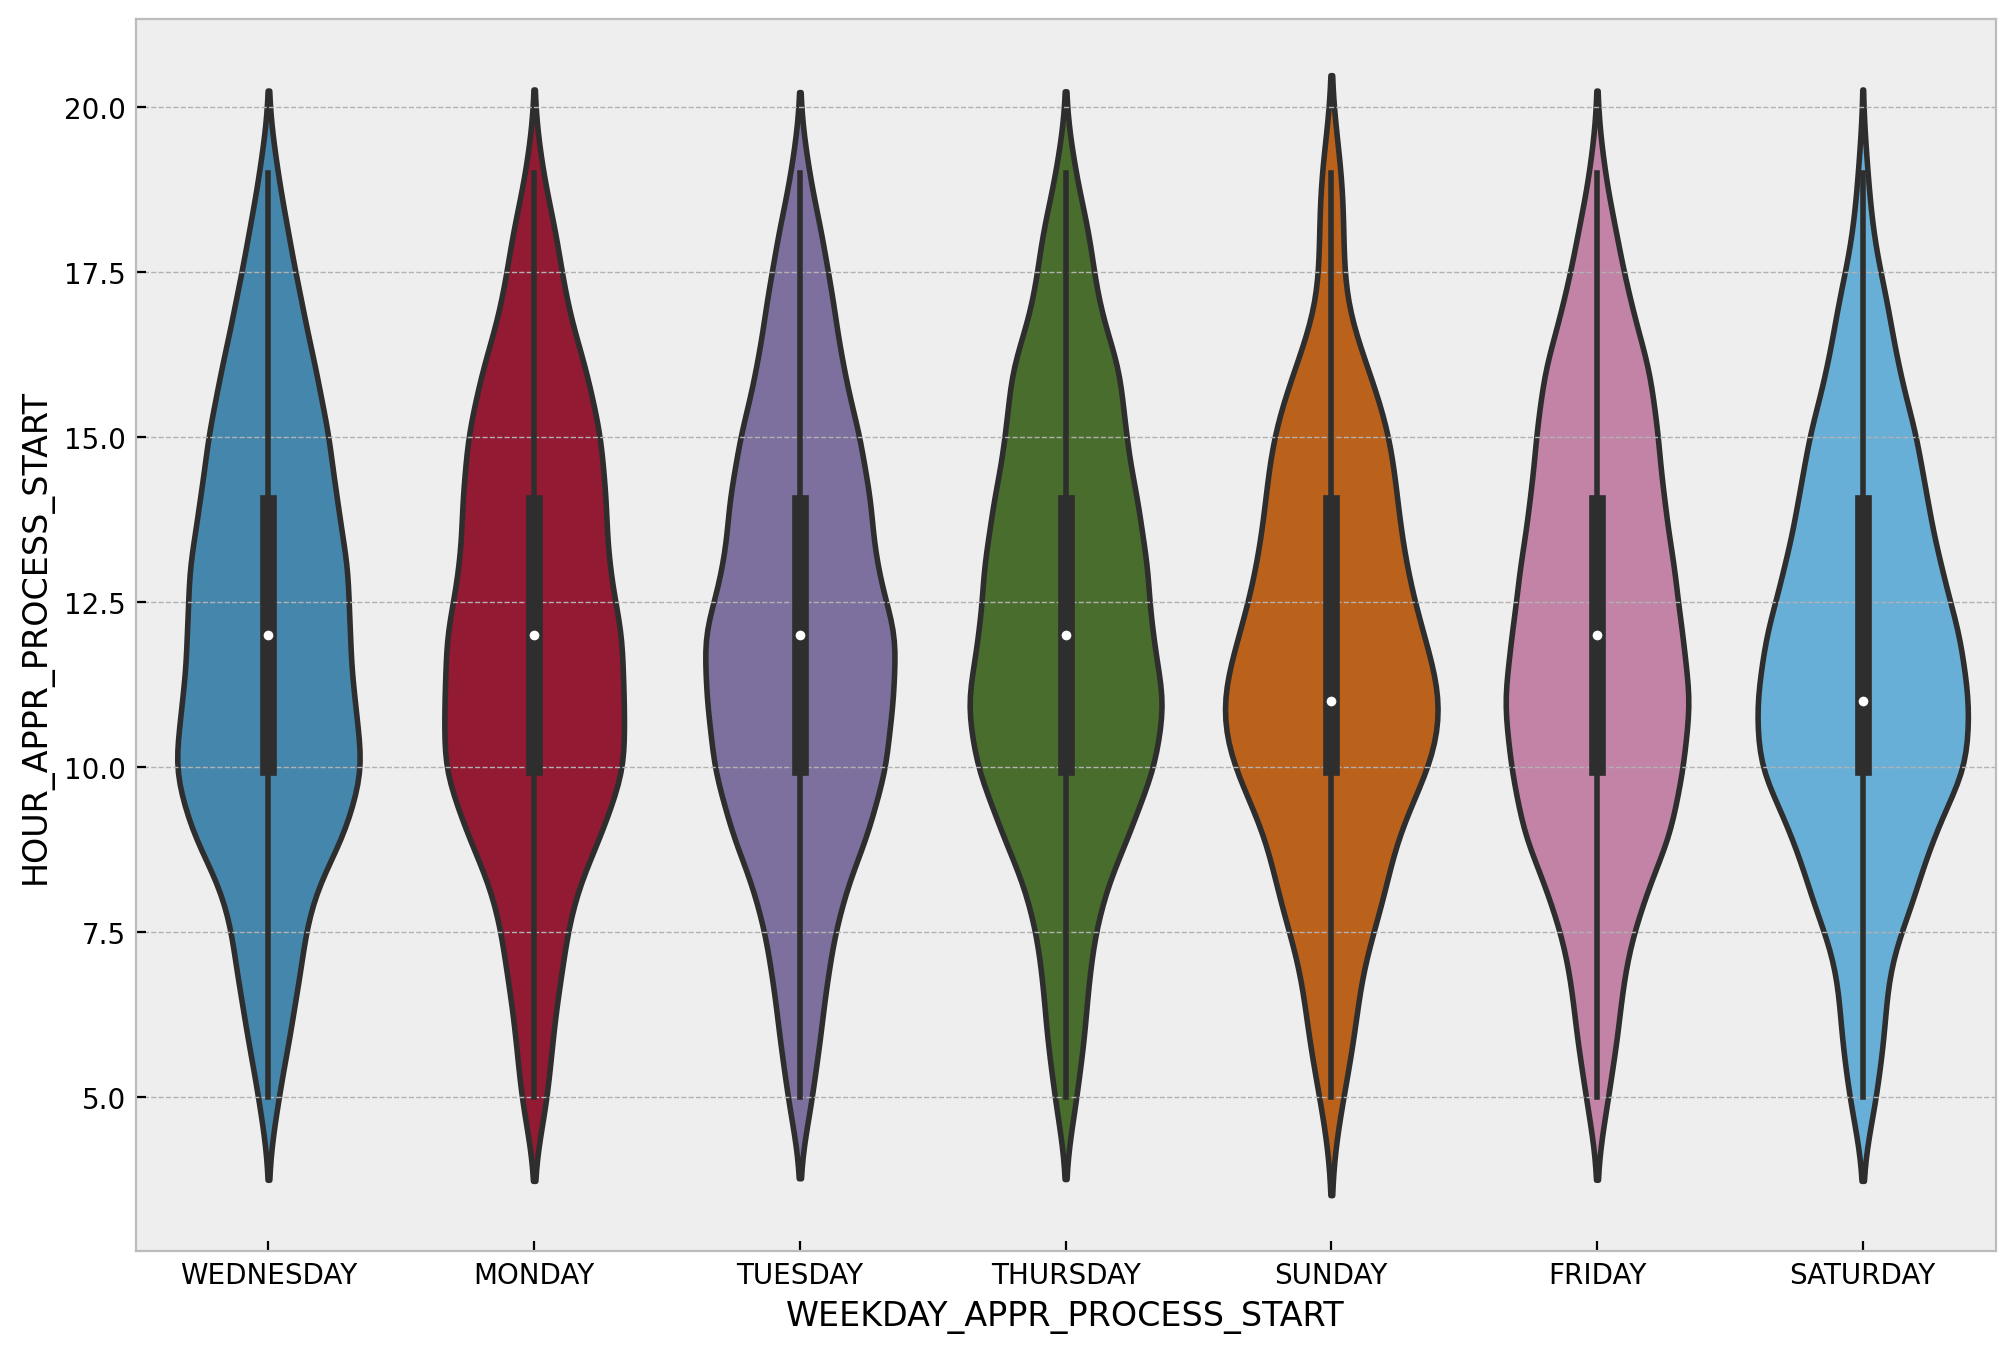

In [18]:
# Violin chart displaying the defaulters are accummulated more at the start of the business hours
sql = '''select hour_appr_process_start, wd.weekday_appr_process_start, target from actual_data_norm ad, 
weekday_appr_process_start wd where ad.weekday_appr_process_start = wd.ID and target = 1'''
df = pd.read_sql_query(sql, conn_norm)

plt.figure(figsize = (12,8), dpi = 200)

sns.violinplot( data = df, y='HOUR_APPR_PROCESS_START', x = 'WEEKDAY_APPR_PROCESS_START')

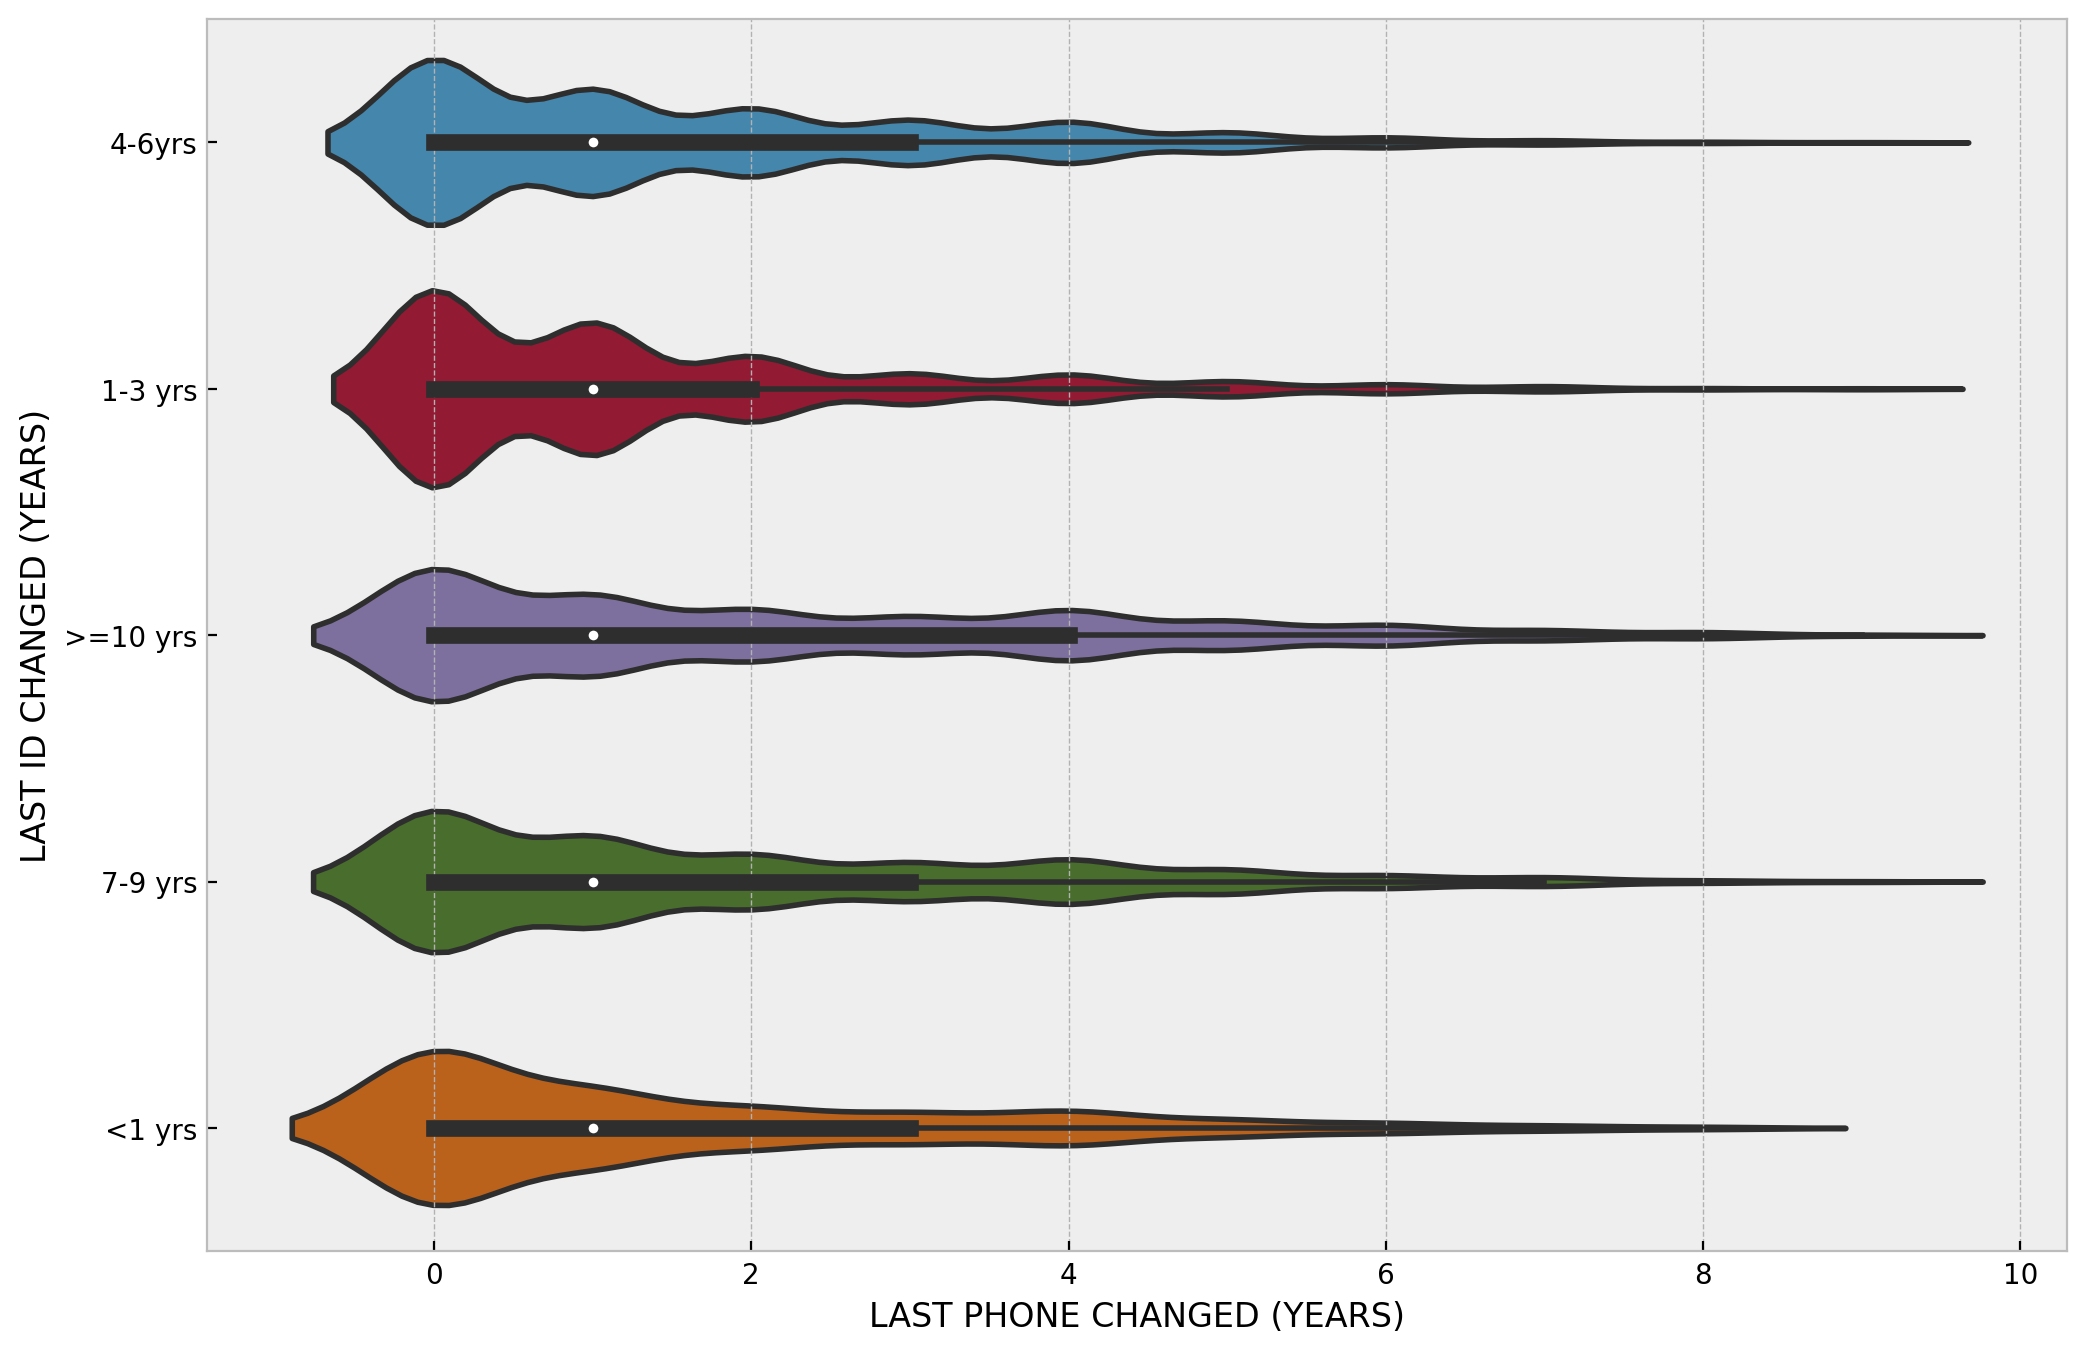

In [19]:
# Violin plot showing defaulters who changed their phone number recently are prone to default.
# it also shows that people who changed their ID document recently are also prone to default.
sql = '''select DAYS_ID_PUBLISH_y,

DAYS_LAST_PHONE_CHANGE_y, target from actual_data_norm ad 
where target = 1'''
df = pd.read_sql_query(sql, conn_norm)

df['ID_CHANGE_CAT'] = df['DAYS_ID_PUBLISH_y'].apply(lambda x: '<1 yrs' if x < 1 else 
                                ('1-3 yrs' if 1<=x<=3 else ('4-6yrs' if 4<=x<=6 else ('7-9 yrs' if 7<=x<=9 else 
                                                                    '>=10 yrs'))))
df['PHONE_CHANGE_CAT'] = df['DAYS_LAST_PHONE_CHANGE_y'].apply(lambda x: '<1 yrs' if x < 1 else 
                                ('1-3 yrs' if 1<=x<=3 else ('4-6yrs' if 4<=x<=6 else ('7-9 yrs' if 7<=x<=9 else 
                                                                    '>=10 yrs'))))

plt.figure(figsize = (12,8), dpi = 200)

fig = sns.violinplot( data = df, y='ID_CHANGE_CAT', x = 'DAYS_LAST_PHONE_CHANGE_y')
fig.set(xlabel = 'LAST PHONE CHANGED (YEARS)', ylabel = 'LAST ID CHANGED (YEARS)')
plt.show()

In [20]:
# Final columns for building model
def fetch_col_data_from_db_using_joins(conn_norm,table_name,col_list):
    sql_start = "select "
    sql_mid = ""
    sql_end = " from "+table_name + " "
    sql_join = ""
    for i in col_list:
        sql_join += "inner join "+ i + " ON " + table_name+"."+i+" = " +i+".ID "
        if not sql_mid:
            sql_mid += i + "." + i
        else:
            sql_mid += ","+i + "." + i
    sql = sql_start+sql_mid+sql_end+sql_join
    df = pd.read_sql_query(sql, conn_norm)
    return df

cat_cols_to_retain = ['NAME_FAMILY_STATUS','CODE_GENDER','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE']
numerical_cols_to_retain= ['DAYS_BIRTH_y','DAYS_EMPLOYED_y','DAYS_ID_PUBLISH_y','DAYS_LAST_PHONE_CHANGE_y','PREV_CLUST']
df_final_numerical = fetch_col_data_from_db(conn_norm,'actual_data_norm', numerical_cols_to_retain)
df_final_categorical = fetch_col_data_from_db_using_joins(conn_norm,'actual_data_norm', cat_cols_to_retain)
df_final_categorical['PREV_CLUST'] = df_final_numerical['PREV_CLUST']
df_final_numerical.drop('PREV_CLUST', axis = 1, inplace = True)
cluster_dict = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}
df_final_categorical.replace({'PREV_CLUST': cluster_dict}, inplace = True)
print(df_final_categorical.shape)
y = df_numerical['TARGET']

(205105, 5)


In [21]:
df_final_categorical.head(5)

,NAME_FAMILY_STATUS,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,PREV_CLUST
0,Single / not married,M,Secondary / secondary special,Working,d
1,Married,F,Higher education,State servant,b
2,Single / not married,M,Secondary / secondary special,Working,b
3,Civil marriage,F,Secondary / secondary special,Working,a
4,Single / not married,M,Secondary / secondary special,Working,a


In [22]:
df_final_numerical.head(5)

,DAYS_BIRTH_y,DAYS_EMPLOYED_y,DAYS_ID_PUBLISH_y,DAYS_LAST_PHONE_CHANGE_y
0,25,1,5,3
1,45,3,0,2
2,52,0,6,2
3,52,8,6,1
4,54,8,9,3


In [23]:
# scaling of numerical df

scaler = StandardScaler()

df_final_numerical_scaled = scaler.fit_transform(df_final_numerical)
numerical_cols_to_retain = ['DAYS_BIRTH_y','DAYS_EMPLOYED_y','DAYS_ID_PUBLISH_y','DAYS_LAST_PHONE_CHANGE_y']
df_final_numerical_scaled = pd.DataFrame(df_final_numerical_scaled,columns=numerical_cols_to_retain)


In [24]:
#  one- hot encoding of categorical features

encoder = OneHotEncoder(sparse=False,drop='if_binary',handle_unknown='ignore')

encoder.fit(df_final_categorical)

df_final_categorical_encoded = encoder.transform(df_final_categorical)
cat_cols_encoded = encoder.get_feature_names()
df_final_categorical_encoded = pd.DataFrame(df_final_categorical_encoded,columns=cat_cols_encoded)

In [25]:
# merging the categorical and numerical dfs
df_final_scaled_encoded = pd.concat([df_final_categorical_encoded,df_final_numerical_scaled],axis=1)

In [26]:
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(df_final_scaled_encoded, y, test_size = 0.2)

In [27]:
# Building model using RandomForest

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# training set performance

y_pred_train = classifier.predict(X_train)

print('# Predicting the TRAIN set results')
print('R2: ',r2_score(y_train,y_pred_train))
print('Accuracy: ', accuracy_score(y_train,y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
print(cm)
print(classification_report(y_train,y_pred_train))

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('# Predicting the TEST set results')
print('R2: ',r2_score(y_test,y_pred))
print('Accuracy: ', accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Predicting the TRAIN set results
R2:  0.7079936153766218
Accuracy:  0.975445503522586
[[148498    379]
 [  3650  11557]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    148877
           1       0.97      0.76      0.85     15207

    accuracy                           0.98    164084
   macro avg       0.97      0.88      0.92    164084
weighted avg       0.98      0.98      0.97    164084

# Predicting the TEST set results
R2:  -0.30203830973475765
Accuracy:  0.888983691280076
[[36336   824]
 [ 3730   131]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     37160
           1       0.14      0.03      0.05      3861

    accuracy                           0.89     41021
   macro avg       0.52      0.51      0.50     41021
weighted avg       0.83      0.89      0.86     41021



In [28]:
df_final_encoded = pd.concat([df_final_categorical_encoded,df_final_numerical],axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_final_encoded, y, test_size = 0.2)
classifier2 = RandomForestClassifier()
classifier2.fit(X_train, y_train)

# training set performance

y_pred_train = classifier2.predict(X_train)

print('# Predicting the TRAIN set results')
print('R2: ',r2_score(y_train,y_pred_train))
print('Accuracy: ', accuracy_score(y_train,y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
print(cm)
print(classification_report(y_train,y_pred_train))

# Predicting the Test set results
y_pred = classifier2.predict(X_test)

print('# Predicting the TEST set results')
print('R2: ',r2_score(y_test,y_pred))
print('Accuracy: ', accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Predicting the TRAIN set results
R2:  0.7099287087735625
Accuracy:  0.975524731235221
[[148378    441]
 [  3575  11690]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    148819
           1       0.96      0.77      0.85     15265

    accuracy                           0.98    164084
   macro avg       0.97      0.88      0.92    164084
weighted avg       0.98      0.98      0.97    164084

# Predicting the TEST set results
R2:  -0.3134598069321073
Accuracy:  0.8895200019502206
[[36369   849]
 [ 3683   120]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     37218
           1       0.12      0.03      0.05      3803

    accuracy                           0.89     41021
   macro avg       0.52      0.50      0.50     41021
weighted avg       0.84      0.89      0.86     41021



In [29]:
# SVM model

X_train, X_test, y_train, y_test = train_test_split(df_final_scaled_encoded, y, test_size = 0.2)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_train = clf.predict(X_train)

print('# Predicting the TRAIN set results')
print('R2: ',r2_score(y_train,y_pred_train))
print('Accuracy: ', accuracy_score(y_train,y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
print(cm)
print(classification_report(y_train,y_pred_train))

# Predicting the Test set results
y_pred = clf.predict(X_test)

print('# Predicting the TEST set results')
print('R2: ',r2_score(y_test,y_pred))
print('Accuracy: ', accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Predicting the TRAIN set results
R2:  -0.10276155739565795
Accuracy:  0.9067611711074816
[[148783      1]
 [ 15298      2]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    148784
           1       0.67      0.00      0.00     15300

    accuracy                           0.91    164084
   macro avg       0.79      0.50      0.48    164084
weighted avg       0.88      0.91      0.86    164084

# Predicting the TEST set results
R2:  -0.10143845266911078
Accuracy:  0.9081202311011434
[[37252     1]
 [ 3768     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     37253
           1       0.00      0.00      0.00      3768

    accuracy                           0.91     41021
   macro avg       0.45      0.50      0.48     41021
weighted avg       0.82      0.91      0.86     41021



In [30]:
# Using different kernel for svm Classifier
clf = svm.SVC(kernel='poly')

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_train = clf.predict(X_train)

print('# Predicting the TRAIN set results')
print('R2: ',r2_score(y_train,y_pred_train))
print('Accuracy: ', accuracy_score(y_train,y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
print(cm)
print(classification_report(y_train,y_pred_train))

# Predicting the Test set results
y_pred = clf.predict(X_test)

print('# Predicting the TEST set results')
print('R2: ',r2_score(y_test,y_pred))
print('Accuracy: ', accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Predicting the TRAIN set results
R2:  -0.10283363802559431
Accuracy:  0.9067550766680481
[[148784      0]
 [ 15300      0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    148784
           1       0.00      0.00      0.00     15300

    accuracy                           0.91    164084
   macro avg       0.45      0.50      0.48    164084
weighted avg       0.82      0.91      0.86    164084

# Predicting the TEST set results
R2:  -0.10114621641210131
Accuracy:  0.9081446088588772
[[37253     0]
 [ 3768     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     37253
           1       0.00      0.00      0.00      3768

    accuracy                           0.91     41021
   macro avg       0.45      0.50      0.48     41021
weighted avg       0.82      0.91      0.86     41021



In [31]:
# Using different kernel for svm Classifier and taking too long execute
clf = svm.SVC(kernel='rbf')

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_train = clf.predict(X_train)

print('# Predicting the TRAIN set results')
print('R2: ',r2_score(y_train,y_pred_train))
print('Accuracy: ', accuracy_score(y_train,y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
print(cm)
print(classification_report(y_train,y_pred_train))

# Predicting the Test set results
y_pred = clf.predict(X_test)

print('# Predicting the TEST set results')
print('R2: ',r2_score(y_test,y_pred))
print('Accuracy: ', accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

In [32]:
# K-nearest neighbor model
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train, y_train)


#Predict the response for test dataset
y_pred_train = classifier.predict(X_train)

print('# Predicting the TRAIN set results')
print('R2: ',r2_score(y_train,y_pred_train))
print('Accuracy: ', accuracy_score(y_train,y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
print(cm)
print(classification_report(y_train,y_pred_train))

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('# Predicting the TEST set results')
print('R2: ',r2_score(y_test,y_pred))
print('Accuracy: ', accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))